In [92]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image # To open the images
import os #Use to find the name of the files (here images) in a directory

from tensorflow.keras.datasets import mnist

from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Activation, Flatten
from tensorflow.keras.utils import to_categorical

In [93]:
# Read images and convert to np.array make lists. 
#Images (image_array_list) for later X and the digit written in each image (image_value_list) for y.  

image_list = []
image_array_list = []
image_value_list = []

objects = ['0','1','2','3','4','5','6','7','8','9']

for ob_idx, ob in enumerate(objects):
    path = "datadig/"+ob

    obj_name_list = os.listdir(path)

    for p_idx,p in enumerate(obj_name_list[0:200]):

        im = Image.open(path+"/"+p)

        image_list.append(im)
        image_array_list.append(np.array(im))
        image_value_list.append(ob_idx)
    print(f'{ob}   {p_idx}')


0   199
1   199
2   199
3   199
4   199
5   199
6   199
7   199
8   199
9   199


In [94]:
image_list[45]

the matrix size of image array is: (28, 28, 4)


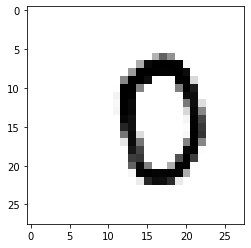

In [95]:
plt.figure(figsize=(8, 4))
plt.imshow(image_array_list[45]) 
print(f'the matrix size of image array is: {image_array_list[45].shape}')

size of read image array                         (2000, 28, 28, 4)
size of image array after choosing 1 color layer (2000, 28, 28)
size of image array after reshape                (2000, 28, 28, 1)
0


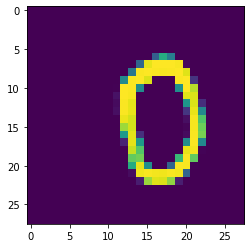

In [96]:
# Convert lists of X and y to arrays:
Xtemp= np.array(image_array_list)
y= np.array(image_value_list)

# !The color is just in layer 3. Layer 0-2 has nothing
X = Xtemp[:,:,:,3]

print(f'size of read image array                         {Xtemp.shape}')
print(f'size of image array after choosing 1 color layer {X.shape}')

# For image recognition using CNN we need 4th component for colors (use reshape)  
X = X.reshape(X.shape[0], 28, 28, 1)
print(f'size of image array after reshape                {X.shape}')

plt.figure(figsize=(8, 4))
plt.imshow(X[45])
print(y[45])



After fitting my CNN fit, I found that the model does not work good for some digits (with very low scores in test set). I concluded this can be related to train-test splitting and maybe I need to shuffle the images before splitting, otherwise the model is not trained correctly.

0


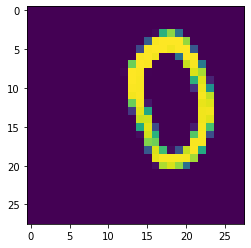

In [97]:
# Shuffle X and y arrays at the same time (with the same order)
def shuffel_arrays(arr1, arr2):
    assert len(arr1) == len(arr2)
    p = np.random.permutation(len(arr1))
    return arr1[p], arr2[p]

# Calling this function
X_sh,y_sh = shuffel_arrays(X,y)
X = X_sh
y = y_sh


plt.figure(figsize=(8, 4))
plt.imshow(X[45])
print(y[45])

In [98]:
from tensorflow.keras.utils import to_categorical
print(f'what is the shape of y? {y.shape}')

# Convert digits(0-9) in y to 10 cells with values=0|1
ycat = to_categorical(y)

what is the shape of y? (2000,)


In [99]:
#Some prints to check the input (X) and outpus (y) for CNN.
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, ycat, test_size=0.3, random_state=42)
print(f'Before y Categorization    X: {X.shape}, and y: {y.shape}')
print(f'After y Categorization     X: {X.shape}, and y: {ycat.shape}')
print('---------------')
print('After categorization and split: ') 
print(f'Shape of train X: {Xtrain.shape}, and y: {ytrain.shape}')
print(f'Shape of test X: {Xtest.shape}, and y: {ytest.shape}')

Before y Categorization    X: (2000, 28, 28, 1), and y: (2000,)
After y Categorization     X: (2000, 28, 28, 1), and y: (2000, 10)
---------------
After categorization and split: 
Shape of train X: (1400, 28, 28, 1), and y: (1400, 10)
Shape of test X: (600, 28, 28, 1), and y: (600, 10)


In [100]:
# Defining model for feature learning (Conv2D and Maxpooling) 
# Then flatten and then Dense layers
K.clear_session()
model = Sequential([

    Conv2D(6, kernel_size=(5,5), strides=(1,1),
           activation='relu', input_shape=Xtrain[0].shape,
           padding='valid'),
    
    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
    
    
    Conv2D(16, kernel_size=(5,5),strides=(1,1),
           activation='relu', padding='valid'),
    
    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
    
    
    Flatten(),
    
    Dense(120, activation='relu'),
    
    Dense(86, activation='relu'),
    
    Dense(len(objects), activation='softmax')
    
])

In [101]:
# Define comile and its parameters
model.compile(optimizer='rmsprop', # type of Gradient Descent 'rmsprop'
              loss='categorical_crossentropy', # multiclass: 'categorical_crossentropy'
              metrics=['accuracy'])

In [102]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 6)         156       
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 6)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 16)          2416      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 4, 4, 16)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 120)               3

In [103]:
# import tensorflow.keras as keras
early_stop = keras.callbacks.EarlyStopping(
    monitor = 'val_loss', #the thing we are monitoring
    min_delta = 0.0005, #the minimum change in the quantity that we want for the model to train for another epoch
    patience = 3, #number of epochs with no improvement needed for the model to stop
    verbose = 1, #0 is silent, 1 means a message is displayed when something happens
    mode = 'auto'  
)

In [104]:
# Model learning, it will stop when conditions in early stop are fullfilled
model.fit(Xtrain, ytrain, epochs=500, batch_size=150, validation_split = 0.2,callbacks = [early_stop])


Epoch 1/500
8/8 [==============================] - 1s 61ms/step - loss: 18.0689 - accuracy: 0.2313 - val_loss: 4.7021 - val_accuracy: 0.3821
Epoch 2/500
8/8 [==============================] - 0s 27ms/step - loss: 3.3204 - accuracy: 0.4616 - val_loss: 2.5284 - val_accuracy: 0.5571
Epoch 3/500
8/8 [==============================] - 0s 28ms/step - loss: 1.7340 - accuracy: 0.6313 - val_loss: 1.5923 - val_accuracy: 0.6500
Epoch 4/500
8/8 [==============================] - 0s 27ms/step - loss: 0.8099 - accuracy: 0.7902 - val_loss: 1.3894 - val_accuracy: 0.7000
Epoch 5/500
8/8 [==============================] - 0s 27ms/step - loss: 0.8318 - accuracy: 0.7839 - val_loss: 0.7440 - val_accuracy: 0.8107
Epoch 6/500
8/8 [==============================] - 0s 26ms/step - loss: 0.2280 - accuracy: 0.9312 - val_loss: 0.7612 - val_accuracy: 0.8250
Epoch 7/500
8/8 [==============================] - 0s 26ms/step - loss: 0.1256 - accuracy: 0.9625 - val_loss: 0.5697 - val_accuracy: 0.8464
Epoch 8/500
8/8 [==

In [105]:
# Predict the test set
ytest_pred = model.predict(Xtest)

19/19 [==============================] - 0s 2ms/step


In [106]:
# Calculating the accuracy of the model for each digit separately

num_Obj=len(objects)
wrong_count_obj = np.zeros((num_Obj,1))
tot_count_obj = np.zeros((num_Obj,1))
test_len = ytest.shape[0]
tot_correct_count = 0

for i in range(ytest.shape[0]):
    b = np.argmax(ytest[i])
    tot_count_obj[b] = tot_count_obj[b]+1
    if(b==np.argmax(ytest_pred[i])):
        tot_correct_count = tot_correct_count +1
    else:
        wrong_count_obj[b] = wrong_count_obj[b]+1
print(f'In test dataset the total number of correct guessess is {tot_correct_count} out of {test_len}')
print(f'score = {round(tot_correct_count/test_len,5)}')
print('----------------')
print('The % of being wrong for each object:\n')
for ob_idx,ob in enumerate(objects):
    print(f'{ob} is guessed wrongly {wrong_count_obj[ob_idx][0]} times out of {tot_count_obj[ob_idx][0]} --> {round(100*wrong_count_obj[ob_idx][0]/tot_count_obj[ob_idx][0])}%')


In test dataset the total number of correct guessess is 563 out of 600
score = 0.93833
----------------
The % of being wrong for each object:

0 is guessed wrongly 7.0 times out of 59.0 --> 12%
1 is guessed wrongly 2.0 times out of 60.0 --> 3%
2 is guessed wrongly 1.0 times out of 54.0 --> 2%
3 is guessed wrongly 6.0 times out of 51.0 --> 12%
4 is guessed wrongly 2.0 times out of 61.0 --> 3%
5 is guessed wrongly 6.0 times out of 59.0 --> 10%
6 is guessed wrongly 2.0 times out of 63.0 --> 3%
7 is guessed wrongly 6.0 times out of 69.0 --> 9%
8 is guessed wrongly 5.0 times out of 60.0 --> 8%
9 is guessed wrongly 0.0 times out of 64.0 --> 0%
